In [1]:
import numpy as np
import pandas as pd
import sys, os, copy, cv2
# sys.path.append('/home/rahim/Desktop/projects/mrob/build/mrobpy/')
import mrob
import matplotlib.pyplot as plt
import open3d as o3d
from tqdm import tqdm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
fx=918.7847900390624
fy=918.74755859375
cx=959.554443359375
cy=553.0713500976563

camera_matrix_azure = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
dist_coeff_azure = np.zeros(5)

In [29]:
root_dir = '/home/mohamad/patata_server/datasets/navigine/12-01-2023-navig-office/azur_rec_1/azur_rec_1/app/vid'
# root_dir = '/home/mohamad/patata_server/datasets/navigine/navigine_second_run/dataset/office_1/'


In [31]:
def read_associations(root_dir, idx):
    with open(root_dir+'/associations.txt') as file:
        lines = file.readlines()
        lines = [line.rstrip() for line in lines]

    associations = []

    for i in lines:
        associations.append(i.split(" ")[1::2])

    return associations[idx-1]
read_associations(root_dir,400)

['/color_pr/000027001855.png', '/depth_pr/000027001866.png']

In [32]:
def quat_to_SE3(quat_pose):
    
    rot_4x1 = quat_pose[-4:]
    tra_3x1 = quat_pose[1:4]

    rot = mrob.geometry.quat_to_so3(rot_4x1)
    pose = mrob.geometry.SE3(mrob.geometry.SO3(rot),tra_3x1)

    return pose

In [33]:
def ax(pose, size = 0.1):
    axis = o3d.geometry.TriangleMesh.create_coordinate_frame(size=size)
    return axis.transform(pose)

In [40]:
def get_data(root_dir, idx):

    pairs = read_associations(root_dir,idx)
    color_dir = root_dir + pairs[0]
    depth_dir = root_dir + pairs[1]
    
    color = o3d.t.io.read_image(color_dir)
    depth = o3d.t.io.read_image(depth_dir)
    return color, depth
c, d = get_data(root_dir, 1201)

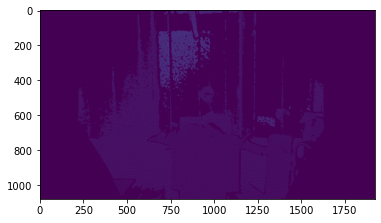

In [41]:
import matplotlib.pyplot as plt
plt.imshow(d)

In [42]:
def get_pcd_pose(root_dir, camera_matrix, idx):

    color, depth = get_data(root_dir, idx)

    cam = o3d.camera.PinholeCameraIntrinsic()
    cam.intrinsic_matrix = camera_matrix

    rgbd = o3d.t.geometry.RGBDImage(color, depth)
                                   
    pcd = o3d.t.geometry.PointCloud.create_from_rgbd_image(rgbd, camera_matrix, depth_scale=1000.0, depth_max=3.0)
    pcd = pcd.to_legacy()

    return pcd

pcd = get_pcd_pose(root_dir, camera_matrix_azure, 541)
pcd

PointCloud with 91112 points.

In [14]:
azure_poses = pd.read_csv(root_dir+'/CameraTrajectory.txt', header=None, sep="\s+")
azu_quat = np.array([each for _,each in azure_poses.iterrows()])
azu_orb = np.zeros((azu_quat.shape[0],4,4))
for i in range(len(azu_quat)):
    pos_ = quat_to_SE3(azu_quat[i,:])
    azu_orb[i,:,:] = pos_.T()

In [15]:
vis_poses = [ax(pose, size = 0.1) for pose in azu_orb[::10]]
o3d.visualization.draw_geometries(vis_poses)


vis_poses = [ax(pose, size = 0.1) for pose in azu_orb[100:600:10]]
o3d.visualization.draw_geometries(vis_poses)


In [19]:
len(azu_orb)

6063

In [22]:
vis_poses = [ax(pose, size = 0.1) for pose in azu_orb[1500:-4000:10]]
o3d.visualization.draw_geometries(vis_poses)

In [25]:
pcds_map = []
poses_map = []
start, end, step = 1500, 4000, 10#len(azu_orb), 500
# start, end, step = 0,len(azu_orb), 50
for idx in tqdm(range(start, end, step)):
    pcd_local = get_pcd_pose(root_dir, camera_matrix_azure, idx)
    pcds_map.append(copy.deepcopy(pcd_local).transform(azu_orb[idx,:,:]))
    poses_map.append(ax(azu_orb[idx,:,:], size = 0.1))

100%|██████████| 250/250 [03:00<00:00,  1.38it/s]


In [26]:
o3d.visualization.draw_geometries(pcds_map + poses_map)

In [73]:
map_3d = o3d.geometry.PointCloud()

for pcd in tqdm(pcds_map):
    points = np.concatenate((np.asarray(map_3d.points), np.asarray(pcd.points)), axis=0)
    colors = np.concatenate((np.asarray(map_3d.colors), np.asarray(pcd.colors)), axis=0)
    map_3d.points = o3d.utility.Vector3dVector(points)
    map_3d.colors = o3d.utility.Vector3dVector(colors)

100%|██████████| 50/50 [00:02<00:00, 20.15it/s]


In [81]:
o3d.visualization.draw_geometries([map_3d])

In [74]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(np.asarray(map_3d.points))

T_rect = mrob.geometry.SE3(mrob.geometry.SO3(pca.components_),np.zeros(3))

aligned_map_rect = copy.deepcopy(map_3d).transform(T_rect.T())

In [21]:
np.save(f"{root_dir}/T_rect", T_rect.T())

In [76]:
o3d.visualization.draw_geometries([aligned_map_rect], window_name='rectified global map')

In [42]:
Points = np.asarray(aligned_map_rect.points)
Colors = np.asarray(aligned_map_rect.colors)
x,y,z = np.asarray(aligned_map_rect.points).T
print('z-axis maximum value: ', z.max())
print('z-axis minimum value: ', z.min())

z-axis maximum value:  0.17325597919382718
z-axis minimum value:  -3.4175062870264172


In [43]:
points_ = list()
colors_ = list()

for x_, y_, z_, point, color in zip(x,y,z, Points, tqdm(Colors)):
    ## specify z-axis threshold to remove top and down points 
    
    # if z_ < z.max()-1 and z_>z.min()+1:   
    if z_ < 1.1 and z_>-2.2:   
        points_.append(point)
        colors_.append(color)

points = np.asarray(points_)
# points[:,2] = 0 # project all points to z=0
colors = np.asarray(colors_)

map_rect_walls = o3d.geometry.PointCloud()
map_rect_walls.points = o3d.utility.Vector3dVector(points)
map_rect_walls.colors = o3d.utility.Vector3dVector(colors)

100%|█████████▉| 13728727/13728728 [00:10<00:00, 1317257.35it/s]


In [45]:
o3d.visualization.draw_geometries([map_rect_walls], window_name='map_rect_walls')

In [ ]:
o3d.io.write_point_cloud(f"{root_dir}/map_rect_walls.pcd", map_rect_walls)